# KMeans Clustering

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn import preprocessing

%matplotlib inline

def printmd(string):
    display(Markdown(string))

## Data Load

In [2]:
TwoDim = pd.read_csv('TwoDimHard.csv')

# Convert to a numpy array
Two = np.array(TwoDim[['X.1','X.2']])

display(TwoDim.head(10))

,ID,X.1,X.2,cluster
0,1,0.276724,0.793762,1
1,2,0.346407,0.797695,1
2,3,0.296033,0.845381,1
3,4,0.333519,0.774505,1
4,5,0.347625,0.737573,1
5,6,0.443881,0.760030,1
6,7,0.358073,0.736421,1
7,8,0.305019,0.722984,1
8,9,0.235237,0.764224,1
9,10,0.304484,0.720066,1


In [3]:
TwoDim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
ID         400 non-null int64
X.1        400 non-null float64
X.2        400 non-null float64
cluster    400 non-null int64
dtypes: float64(2), int64(2)
memory usage: 12.6 KB


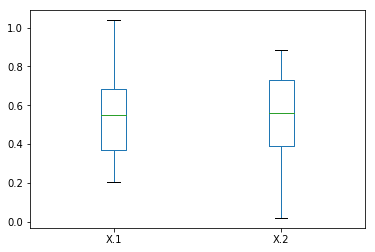

In [4]:
TwoDim.drop(columns = ['ID', 'cluster']).plot(kind = 'box')

In [31]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, 9 + n)[9 + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    SSE, SSB = 0, 0
    SSE_cluster = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        SSE += temp
        SSE_cluster.append(temp)
        
    return SSE, SSB, SSE_cluster


## True Cluster Membership

SSB : 95.400839
SSE : 39.600296
Cluster-wise SSE:
Cluster 1: 4.500000
Cluster 2: 8.410000
Cluster 3: 13.730000
Cluster 4: 12.950000


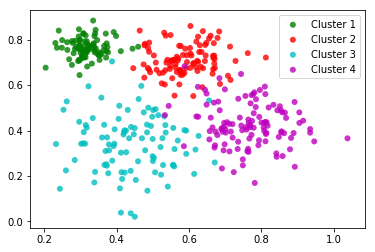

In [85]:
groups = TwoDim.groupby('cluster')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group['X.1'], group['X.2'],alpha=0.8, c=colors[name], edgecolors='none', label='Cluster '+str(name))
ax.legend()


printmd('## True Cluster Membership')
SSE, SSB, SSE_cluster = calculateMeasures(Two, TwoDim.cluster.values, updateCentroids(Two, TwoDim.cluster.values, np.zeros((4,Two.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
plt.show()

In [145]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(4, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 40.030522 & Mean SSB : 95.352469


37.97 | 96.34    85
50.82 | 91.24     5
53.65 | 84.46     2
51.13 | 90.8      1
50.79 | 90.84     1
50.77 | 91.06     1
53.9 | 90.7       1
50.78 | 91.12     1
51.37 | 91.93     1
50.79 | 90.85     1
54.56 | 84.19     1
dtype: int64

## Clustering Plot k = 4

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 9.480000
Cluster 2: 11.190000
Cluster 3: 11.770000
Cluster 4: 5.530000

Iteration till convergence : 8


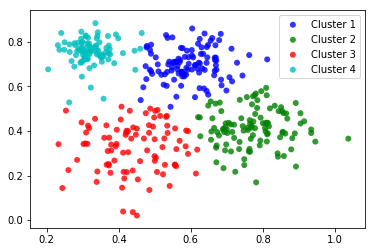

In [143]:
centroids, iterations, clusters = KMeans(4, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 4')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [136]:
new_clusters = []
for i in clusters:
    if i == 3:
        new_clusters.append(1)
    elif i == 2:
        new_clusters.append(2)
    elif i == 1:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,2,4,0
2,0,98,2,8
3,0,0,88,2
4,0,0,3,104


## K = 3

In [149]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(3, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 53.893691 & Mean SSB : 88.441353


53.88 | 90.64    40
53.9 | 90.7      27
53.65 | 84.46    17
53.74 | 84.41     9
53.78 | 84.39     3
53.92 | 84.42     2
59.4 | 68.06      1
54.55 | 84.13     1
dtype: int64

## Clustering Plot k = 3

SSB : 90.636953
SSE : 53.881737
Cluster-wise SSE:
Cluster 1: 12.220000
Cluster 2: 13.810000
Cluster 3: 27.850000

Iteration till convergence : 6


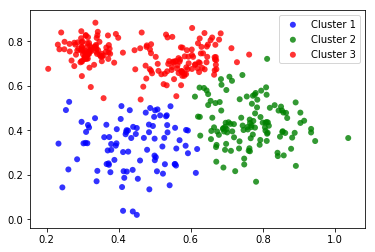

In [147]:
centroids, iterations, clusters = KMeans(3, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 3')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [ ]:
new_clusters = []
for i in clusters:
    if i == 3:
        new_clusters.append(1)
    elif i == 2:
        new_clusters.append(2)
    elif i == 1:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


In [49]:
# Sampling Centroids
SSE, SSB = [], []
for i in range(100):
    cent = reallyreallyInitializeCentroids(Two, 4)
    centroids, iterations, clusters = KMeans(4, Two, cent)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

Centroids replaced 175 time(s).
Centroids replaced 152 time(s).
Centroids replaced 70 time(s).
Centroids replaced 147 time(s).
Centroids replaced 288 time(s).
Centroids replaced 140 time(s).
Centroids replaced 260 time(s).
Centroids replaced 196 time(s).
Centroids replaced 128 time(s).
Centroids replaced 182 time(s).
Centroids replaced 157 time(s).
Centroids replaced 92 time(s).
Centroids replaced 81 time(s).
Centroids replaced 149 time(s).
Centroids replaced 233 time(s).
Centroids replaced 86 time(s).
Centroids replaced 128 time(s).
Centroids replaced 192 time(s).
Centroids replaced 149 time(s).
Centroids replaced 155 time(s).
Centroids replaced 179 time(s).
Centroids replaced 247 time(s).
Centroids replaced 145 time(s).
Centroids replaced 273 time(s).
Centroids replaced 288 time(s).
Centroids replaced 191 time(s).
Centroids replaced 113 time(s).
Centroids replaced 179 time(s).
Centroids replaced 121 time(s).
Centroids replaced 260 time(s).
Centroids replaced 171 time(s).
Centroids re

Centroids replaced 196 time(s).


## Clustering Plot

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 9.480000
Cluster 2: 11.770000
Cluster 3: 11.190000
Cluster 4: 5.530000


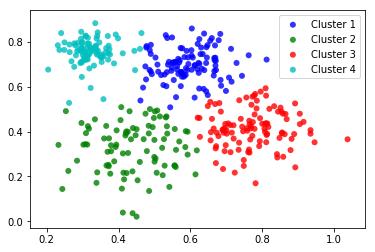

In [45]:
cent = reallyreallyInitializeCentroids(Two, 4)
centroids, iterations, clusters = KMeans(4, Two, cent)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))


plt.show()

## Ideal K Value

In [160]:
SSE_per_k = []
for j in range(1,11):
    print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(100):
        centroids, iterations, clusters = KMeans(j, Two)
        t1, t2, _ = calculateMeasures(Two, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k.append(np.mean(SSE))

Calculating for k : 1
Calculating for k : 2
Calculating for k : 3
Calculating for k : 4
Calculating for k : 5
Calculating for k : 6
Calculating for k : 7
Calculating for k : 8
Calculating for k : 9
Calculating for k : 10


Text(0,0.5,'SSE')

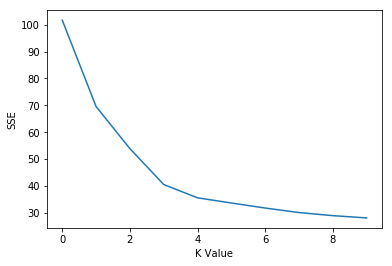

In [164]:
#SSE_per_k
ax = pd.Series(SSE_per_k, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Wine Data Clustering

In [ ]:
wine = pd.read_csv('winequality-red.csv', sep = ';')
Wine_Base = np.array(wine.drop(columns = ['quality']))
Wine_Norm = preprocessing.normalize(wine.drop(columns = ['quality']))

In [ ]:
centroids, iterations, clusters = KMeans(10, Wine_Base)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

In [ ]:
centroids, iterations, clusters = KMeans(10, Wine_Norm)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

In [ ]:
cent = reallyreallyInitializeCentroids(Wine_Norm, 10)
_, iterations, clusters = KMeans(10, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

In [ ]:
cent = reallyreallyInitializeCentroids(Wine_Base, 10)
_, iterations, clusters = KMeans(10, Wine_Base, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

In [ ]:
wine.quality.value_counts()
        

In [ ]:
len(np.where(clusters == 1+1)[0])